# Pneumonia Image Classification - Neural Network Analysis 

**Authors** [Clara Giurgiu](mailto:claragiurgiu@gmail.com), [Vlad Sekiguchi](mailto:vlsekig@gmail.com)


## Overview

For this project we use a Sequential Neural Network model to analyze and recognize pneumonia patterns amongst thousands of pediatric patients' x-rays. Through an iterative process of enhancing certain features in the images and using a convoluted neural networks, we were able to improve our model's classification capabilities.



## Business Problem
In order to help the radiology department in our hospital, we were tasked with using deep learning algorithms to streamline detection and diagnosis of pneumonia from x-ray images. Thus, delivering treatment and/or resources to patients in a timely manner and reduce the cost of treating for complications or patients that were misdiagnosed. 

Pneumonia is an infection of the lower respiratory track that can be caused by viruses or bacteria. It results in inflamation of the alveoli, wich are air sacs in the the lungs. This infection can be life-threateting especially amongst children and people over 65.
According to the National Institute of Health (NIH), pneumonia is a leading cause of mortality in children younger than 5 years of age, globally, with as many as 1.3 million deaths annually. 
There are a few diagnostic tools to detect pneumonia, and quite often patients are prescribed to do chest x-rays when pneumonia is suspected. 
Our goal for this project is developing a neural network model to look at those x-rays images and predict whether pneumonia is present or not in order to help doctos and healthcare providers address this concerning issue affecting our children. 
Misdiagnosing or not detecting pneumonia in its early stages can lead to severe complications and sometimes death. Our model will focus on accuracy and reducing the change of missing the infection, or recall. 

## Data
This project uses the x-ray images provided by the [University of California San Diego and Guangzhou Women and Children's Medical Center](https://data.mendeley.com/datasets/rscbjbr9sj/3). The images can be found in the chest_xray folder of this project's repository, with approximately 5,800 images separated into train and test and labeled with 'Normal' or 'Pneumonia.'

## Data Preparation

In [1]:
# importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image, ImageFile
import os
import glob
from tqdm import tqdm

# modeling and neural network libs
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.metrics import Accuracy, Recall

In [2]:
# creating path to train and test data folders
train_path = 'chest_xray/train/'
test_path = 'chest_xray/test/'

In [3]:
# dividing train into normal and pneumonia paths for visualization
train_neg_filepath = 'chest_xray/train/NORMAL/'
train_pos_filepath = 'chest_xray/train/PNEUMONIA/'

# matching to jpeg image
files_train_neg = glob.glob(os.path.join(train_neg_filepath,'*.jpeg'))
files_train_pos = glob.glob(os.path.join(train_pos_filepath,'*.jpeg'))

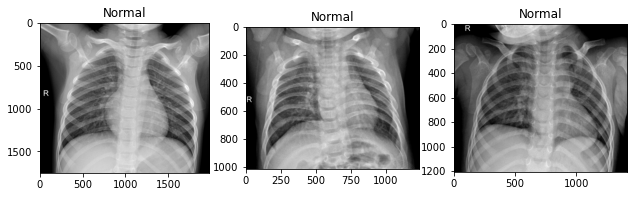

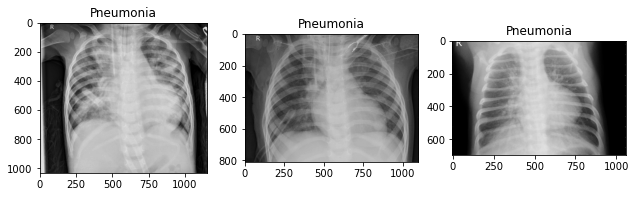

In [4]:
# visualizing normal vs abnormal x-rays
plt.figure(figsize=(18,16))
for i in range(3):
    img = files_train_neg[i]
    img = Image.open(img)
    ax = plt.subplot(5,5,i+1)
    plt.imshow(img, cmap ='gray')
    plt.title("Normal")
    
plt.figure(figsize=(18,16))
for i in range(3):
    img2 = files_train_pos[i]
    img2 = Image.open(img2)
    ax = plt.subplot(5,5,i+1)
    plt.imshow(img2, cmap ='gray')
    plt.title("Pneumonia")
    

In [5]:
# using image data generator to model 
# batch size=32
idata_gen = ImageDataGenerator(rescale=1/255, validation_split = 0.20)


#training dir
train_set = idata_gen.flow_from_directory(train_path, target_size=(64, 64), color_mode='grayscale',
                                         class_mode='binary', subset='training', seed=42)

validation_set = idata_gen.flow_from_directory(train_path, target_size=(64, 64),color_mode='grayscale',
                                              class_mode='binary', subset='validation', seed=42)

# testing dir
test_set = idata_gen.flow_from_directory(test_path, target_size=(64, 64), color_mode='grayscale',
                                        class_mode='binary', shuffle=False, seed=42)

Found 4186 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# dummy set for baseline model
dummy_train_set = idata_gen.flow_from_directory(train_path, target_size=(64, 64), color_mode='grayscale',
                                         class_mode='binary', subset='training', seed=42,
                                               batch_size=4186)

Found 4186 images belonging to 2 classes.


## Methods
We transformed the images using ImageDataGenerator and then used a Sequential Neural Network. In order to measure the minimization of false negatives, both accuracy and recall scores were used to reflect the model's success. To analyze the model's improvement, we used a dummy model that evenly picks 50/50 between positive and negative diagnostics. The next steps after the Sequential model were to enhance the images via ImageDataGenerator and retrain the model, and then use a convoluted neural network to further improve the model.

### Dummy Model

In [7]:
train_x, train_y = next(dummy_train_set)

In [8]:
baseline_model = DummyClassifier(strategy='uniform')
baseline_model.fit(train_x, train_y)

DummyClassifier(strategy='uniform')

In [9]:
dummy_acc = baseline_model.score(train_x, train_y)
dummy_acc

0.49498327759197325

In [10]:
cross_val_score(baseline_model, train_x, train_y)

array([0.49522673, 0.48506571, 0.47192354, 0.49223417, 0.50657109])

In [11]:
dummy_preds = baseline_model.predict(train_x)

In [12]:
dummy_rec = recall_score(train_y, dummy_preds)
dummy_rec

0.5172191824911491

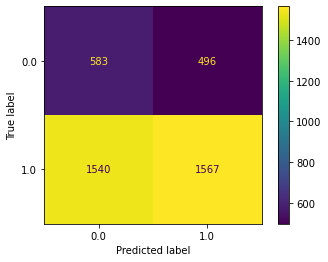

In [13]:
plot_confusion_matrix(baseline_model, train_x, train_y)

### Simple Neural Network

In [47]:
simple_model = Sequential()
simple_model.add(Flatten(input_shape=(64,64,1)))
simple_model.add(Dense(20, activation='relu'))
simple_model.add(Dense(7, activation='relu'))
simple_model.add(Dense(5, activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))

simple_model.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy', Recall(name='recall')])

simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                81940     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 82,133
Trainable params: 82,133
Non-trainable params: 0
_________________________________________________________________


In [48]:
simple_results = simple_model.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 28s 215ms/step - loss: 0.4416 - accuracy: 0.7893 - recall: 0.9926 - val_loss: 0.2896 - val_accuracy: 0.9072 - val_recall: 0.9871
Epoch 2/30
131/131 [==============================] - 27s 205ms/step - loss: 0.2960 - accuracy: 0.8915 - recall: 0.9829 - val_loss: 0.2274 - val_accuracy: 0.9321 - val_recall: 0.9871
Epoch 3/30
131/131 [==============================] - 27s 204ms/step - loss: 0.2299 - accuracy: 0.9319 - recall: 0.9694 - val_loss: 0.1739 - val_accuracy: 0.9579 - val_recall: 0.9781
Epoch 4/30
131/131 [==============================] - 27s 203ms/step - loss: 0.2039 - accuracy: 0.9307 - recall: 0.9601 - val_loss: 0.1470 - val_accuracy: 0.9608 - val_recall: 0.9626
Epoch 5/30
131/131 [==============================] - 27s 203ms/step - loss: 0.1628 - accuracy: 0.9446 - recall: 0.9630 - val_loss: 0.1252 - val_accuracy: 0.9636 - val_recall: 0.9832
Epoch 6/30
131/131 [==============================] - 27s 206ms/step - loss: 0.1524 -

In [51]:
simple_results.history

{'loss': [0.44156020879745483,
  0.2959808111190796,
  0.22988706827163696,
  0.20386631786823273,
  0.16275878250598907,
  0.152441143989563,
  0.15360116958618164,
  0.13269323110580444,
  0.15962111949920654,
  0.12436763197183609,
  0.13043315708637238,
  0.12215426564216614,
  0.129491925239563,
  0.1150645911693573,
  0.11023665219545364,
  0.12367825210094452,
  0.13435880839824677,
  0.10294193774461746,
  0.10927098244428635,
  0.09996093809604645,
  0.09382478147745132,
  0.08891421556472778,
  0.09060503542423248,
  0.09900306165218353,
  0.11784599721431732,
  0.08804766833782196,
  0.09248978644609451,
  0.08414378017187119,
  0.10911565274000168,
  0.09006088972091675],
 'accuracy': [0.7892976403236389,
  0.8915432691574097,
  0.9319159388542175,
  0.9307214617729187,
  0.944577157497406,
  0.9460105299949646,
  0.9414715766906738,
  0.9512661099433899,
  0.9397993087768555,
  0.9543716907501221,
  0.952221691608429,
  0.9555661678314209,
  0.9512661099433899,
  0.9591495

<AxesSubplot:>

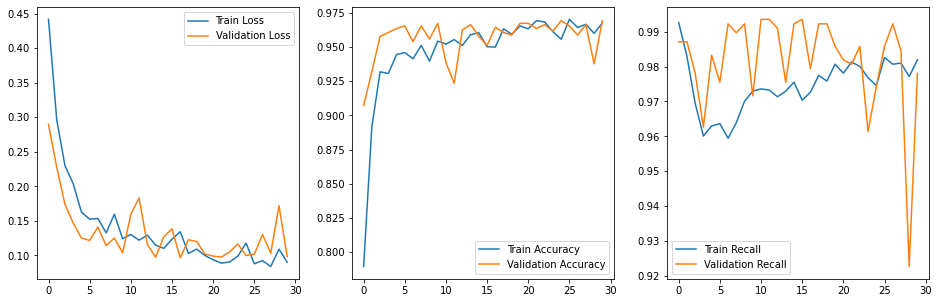

In [53]:
# code sampled from lecture
train_loss = simple_results.history['loss']
train_acc = simple_results.history['accuracy']
train_rec = simple_results.history['recall']
val_loss = simple_results.history['val_loss']
val_acc = simple_results.history['val_accuracy']
val_rec = simple_results.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=simple_results.epoch, y=train_loss, ax=ax1, label='Train Loss')
sns.lineplot(x=simple_results.epoch, y=train_acc, ax=ax2, label='Train Accuracy')
sns.lineplot(x=simple_results.epoch, y=train_rec, ax=ax3, label='Train Recall')

sns.lineplot(x=simple_results.epoch, y=val_loss, ax=ax1, label='Validation Loss')
sns.lineplot(x=simple_results.epoch, y=val_acc, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=simple_results.epoch, y=val_rec, ax=ax3, label='Validation Recall')


In [54]:
simple_model.evaluate(validation_set)

33/33 [==============================] - 5s 153ms/step - loss: 0.0984 - accuracy: 0.9694 - recall: 0.9781


[0.09838473051786423, 0.9693779945373535, 0.9780927896499634]

The simple neural network shows substantial improment from the baseline model. We want to use the ImageDataGenerator to augment the training data and see if it increases our accuracy and recall.

### Data Augmentation

In [14]:
# adding parameters to generator to use on training set
datagen_aug = ImageDataGenerator(rescale=1/255,
                                   validation_split = 0.20,
                                   rotation_range=40, 
                                   brightness_range=(0.1,0.9),
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_set2 = datagen_aug.flow_from_directory(train_path, target_size=(64, 64), 
                                         color_mode='grayscale', class_mode='binary', subset='training', seed=42)

Found 4186 images belonging to 2 classes.


### Simple Neural Network With Data Augmentation

In [56]:
aug_model = Sequential()
aug_model.add(Flatten(input_shape=(64,64,1)))
aug_model.add(Dense(20, activation='relu'))
aug_model.add(Dense(7, activation='relu'))
aug_model.add(Dense(5, activation='relu'))
aug_model.add(Dense(1, activation='sigmoid'))

aug_model.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy', Recall(name='recall')])

aug_results = aug_model.fit(train_set2, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 29s 221ms/step - loss: 0.5704 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.5661 - val_accuracy: 0.7426 - val_recall: 1.0000
Epoch 2/30
131/131 [==============================] - 28s 217ms/step - loss: 0.5618 - accuracy: 0.7427 - recall: 0.9974 - val_loss: 0.5753 - val_accuracy: 0.7981 - val_recall: 0.7616
Epoch 3/30
131/131 [==============================] - 28s 217ms/step - loss: 0.5590 - accuracy: 0.7422 - recall: 0.9997 - val_loss: 0.5405 - val_accuracy: 0.7426 - val_recall: 1.0000
Epoch 4/30
131/131 [==============================] - 28s 217ms/step - loss: 0.5506 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.4603 - val_accuracy: 0.7426 - val_recall: 1.0000
Epoch 5/30
131/131 [==============================] - 28s 217ms/step - loss: 0.5400 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.4612 - val_accuracy: 0.7426 - val_recall: 1.0000
Epoch 6/30
131/131 [==============================] - 28s 216ms/step - loss: 0.5504 -

In [57]:
aug_model.evaluate(validation_set)

33/33 [==============================] - 5s 153ms/step - loss: 0.3648 - accuracy: 0.8402 - recall: 0.9536


[0.3648275136947632, 0.8401913642883301, 0.9536082744598389]

<AxesSubplot:>

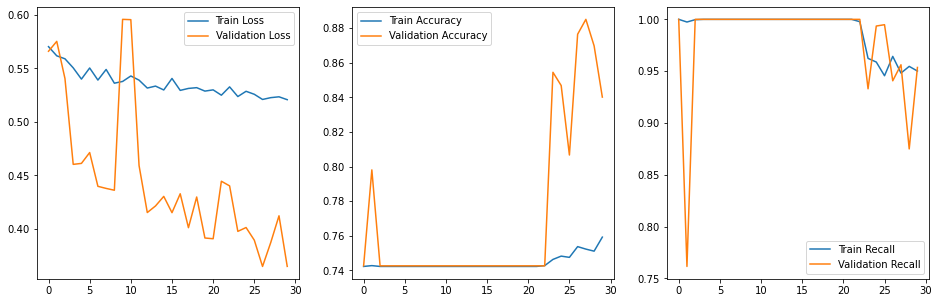

In [58]:
train_loss2 = aug_results.history['loss']
train_acc2 = aug_results.history['accuracy']
train_rec2 = aug_results.history['recall']
val_loss2 = aug_results.history['val_loss']
val_acc2 = aug_results.history['val_accuracy']
val_rec2 = aug_results.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=aug_results.epoch, y=train_loss2, ax=ax1, label='Train Loss')
sns.lineplot(x=aug_results.epoch, y=train_acc2, ax=ax2, label='Train Accuracy')
sns.lineplot(x=aug_results.epoch, y=train_rec2, ax=ax3, label='Train Recall')

sns.lineplot(x=aug_results.epoch, y=val_loss2, ax=ax1, label='Validation Loss')
sns.lineplot(x=aug_results.epoch, y=val_acc2, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=aug_results.epoch, y=val_rec2, ax=ax3, label='Validation Recall')

After using augmented training set, the model seems to be doing worse. We will try a convoluted neural network with the same training set.

### Convolutional Neural Network With Data Augmentation

In [93]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D((2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
              
cnn_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                802880    
_________________________________________________________________
dense_30 (Dense)             (None, 1)               

In [94]:
# fitting to aug train
cnn_results = cnn_model.fit(train_set2, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 30s 229ms/step - loss: 0.5443 - accuracy: 0.7382 - recall: 0.9491 - val_loss: 0.4563 - val_accuracy: 0.8459 - val_recall: 0.8866
Epoch 2/30
131/131 [==============================] - 29s 224ms/step - loss: 0.4145 - accuracy: 0.8010 - recall: 0.9179 - val_loss: 0.2666 - val_accuracy: 0.8880 - val_recall: 0.8840
Epoch 3/30
131/131 [==============================] - 29s 224ms/step - loss: 0.3583 - accuracy: 0.8318 - recall: 0.9083 - val_loss: 0.3341 - val_accuracy: 0.8593 - val_recall: 0.8157
Epoch 4/30
131/131 [==============================] - 29s 224ms/step - loss: 0.3464 - accuracy: 0.8366 - recall: 0.9038 - val_loss: 0.2484 - val_accuracy: 0.9033 - val_recall: 0.8943
Epoch 5/30
131/131 [==============================] - 29s 224ms/step - loss: 0.3412 - accuracy: 0.8416 - recall: 0.9108 - val_loss: 0.2183 - val_accuracy: 0.9129 - val_recall: 0.9021
Epoch 6/30
131/131 [==============================] - 29s 224ms/step - loss: 0.3153 -

In [97]:
cnn_model.evaluate(validation_set)

33/33 [==============================] - 5s 154ms/step - loss: 0.2300 - accuracy: 0.9120 - recall: 0.8969


[0.22997871041297913, 0.9119617342948914, 0.8969072103500366]

<AxesSubplot:>

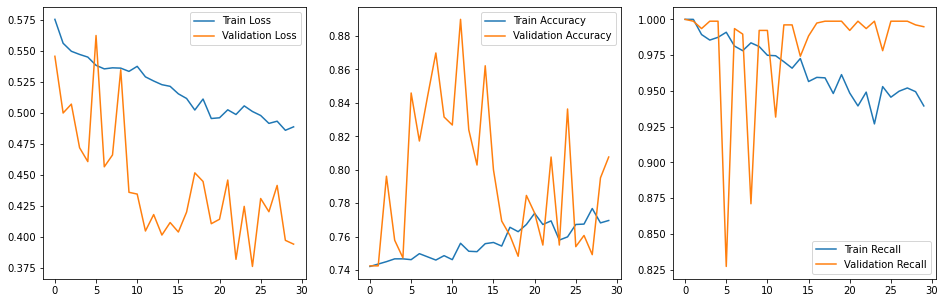

In [95]:
cnn_train_loss = cnn_results.history['loss']
cnn_train_acc = cnn_results.history['accuracy']
cnn_train_rec = cnn_results.history['recall']
cnn_val_loss = cnn_results.history['val_loss']
cnn_val_acc = cnn_results.history['val_accuracy']
cnn_val_rec = cnn_results.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=cnn_results.epoch, y=cnn_train_loss, ax=ax1, label='Train Loss')
sns.lineplot(x=cnn_results.epoch, y=cnn_train_acc, ax=ax2, label='Train Accuracy')
sns.lineplot(x=cnn_results.epoch, y=cnn_train_rec, ax=ax3, label='Train Recall')

sns.lineplot(x=cnn_results.epoch, y=cnn_val_loss, ax=ax1, label='Validation Loss')
sns.lineplot(x=cnn_results.epoch, y=cnn_val_acc, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=cnn_results.epoch, y=cnn_val_rec, ax=ax3, label='Validation Recall')

### Convolutional Neural Network  WITHOUT Data Augmentation

In [98]:
cnn_model1 = Sequential()
cnn_model1.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(64, 64, 1)))
cnn_model1.add(MaxPooling2D(pool_size=(2,2)))
cnn_model1.add(Conv2D(64, (3,3), activation='relu'))
cnn_model1.add(MaxPooling2D((2,2)))
cnn_model1.add(Flatten())
cnn_model1.add(Dense(64, activation='relu'))
cnn_model1.add(Dense(1, activation='sigmoid'))
              
cnn_model1.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

# fitting to normal train
cnn_results1 = cnn_model1.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 30s 228ms/step - loss: 0.2812 - accuracy: 0.8798 - recall: 0.9640 - val_loss: 0.0921 - val_accuracy: 0.9703 - val_recall: 0.9755
Epoch 2/30
131/131 [==============================] - 29s 225ms/step - loss: 0.1322 - accuracy: 0.9496 - recall: 0.9685 - val_loss: 0.1059 - val_accuracy: 0.9608 - val_recall: 0.9523
Epoch 3/30
131/131 [==============================] - 29s 223ms/step - loss: 0.1058 - accuracy: 0.9620 - recall: 0.9762 - val_loss: 0.0924 - val_accuracy: 0.9589 - val_recall: 0.9549
Epoch 4/30
131/131 [==============================] - 29s 222ms/step - loss: 0.0940 - accuracy: 0.9634 - recall: 0.9765 - val_loss: 0.0837 - val_accuracy: 0.9646 - val_recall: 0.9613
Epoch 5/30
131/131 [==============================] - 30s 229ms/step - loss: 0.0795 - accuracy: 0.9699 - recall: 0.9804 - val_loss: 0.0815 - val_accuracy: 0.9646 - val_recall: 0.9923
Epoch 6/30
131/131 [==============================] - 29s 225ms/step - loss: 0.0640 -

In [99]:
cnn_model1.evaluate(validation_set)

33/33 [==============================] - 5s 159ms/step - loss: 0.1297 - accuracy: 0.9789 - recall: 0.9871


[0.12965843081474304, 0.9789473414421082, 0.9871134161949158]

<AxesSubplot:>

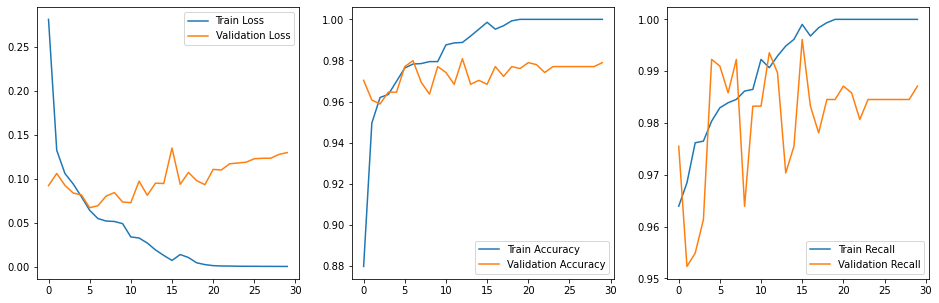

In [104]:
cnn_train_loss1 = cnn_results1.history['loss']
cnn_train_acc1 = cnn_results1.history['accuracy']
cnn_train_rec1 = cnn_results1.history['recall']
cnn_val_loss1 = cnn_results1.history['val_loss']
cnn_val_acc1 = cnn_results1.history['val_accuracy']
cnn_val_rec1 = cnn_results1.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=cnn_results1.epoch, y=cnn_train_loss1, ax=ax1, label='Train Loss')
sns.lineplot(x=cnn_results1.epoch, y=cnn_train_acc1, ax=ax2, label='Train Accuracy')
sns.lineplot(x=cnn_results1.epoch, y=cnn_train_rec1, ax=ax3, label='Train Recall')

sns.lineplot(x=cnn_results1.epoch, y=cnn_val_loss1, ax=ax1, label='Validation Loss')
sns.lineplot(x=cnn_results1.epoch, y=cnn_val_acc1, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=cnn_results1.epoch, y=cnn_val_rec1, ax=ax3, label='Validation Recall')

After modeling a simple network and convoluted neural network without and with augmented data, it is clear that augmentation did not improve our model. We will iterated other CNNs without augmented images and adjust other parameters. 

### Convolutional Neural Network With 1 Dropout Layer

In [106]:
cnn_model2 = Sequential()
cnn_model2.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(64, 64, 1)))
cnn_model2.add(MaxPooling2D(pool_size=(2,2)))
cnn_model2.add(Conv2D(64, (3,3), activation='relu'))
cnn_model2.add(MaxPooling2D((2,2)))
cnn_model2.add(Dropout(0.2))
cnn_model2.add(Flatten())
cnn_model2.add(Dense(64, activation='relu'))
cnn_model2.add(Dense(1, activation='sigmoid'))
              
cnn_model2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

# fitting to normal train
cnn_results2 = cnn_model2.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 29s 223ms/step - loss: 0.2857 - accuracy: 0.8813 - recall: 0.9649 - val_loss: 0.1378 - val_accuracy: 0.9579 - val_recall: 0.9536
Epoch 2/30
131/131 [==============================] - 29s 218ms/step - loss: 0.1286 - accuracy: 0.9498 - recall: 0.9675 - val_loss: 0.1105 - val_accuracy: 0.9579 - val_recall: 0.9910
Epoch 3/30
131/131 [==============================] - 29s 218ms/step - loss: 0.1020 - accuracy: 0.9591 - recall: 0.9749 - val_loss: 0.0910 - val_accuracy: 0.9656 - val_recall: 0.9936
Epoch 4/30
131/131 [==============================] - 28s 217ms/step - loss: 0.0910 - accuracy: 0.9632 - recall: 0.9755 - val_loss: 0.0742 - val_accuracy: 0.9770 - val_recall: 0.9910
Epoch 5/30
131/131 [==============================] - 28s 217ms/step - loss: 0.0775 - accuracy: 0.9711 - recall: 0.9804 - val_loss: 0.0661 - val_accuracy: 0.9761 - val_recall: 0.9794
Epoch 6/30
131/131 [==============================] - 29s 218ms/step - loss: 0.0586 -

In [110]:
cnn_model2.evaluate(validation_set)

33/33 [==============================] - 5s 158ms/step - loss: 0.0772 - accuracy: 0.9780 - recall: 0.9820


[0.07715970277786255, 0.977990448474884, 0.9819587469100952]

<AxesSubplot:>

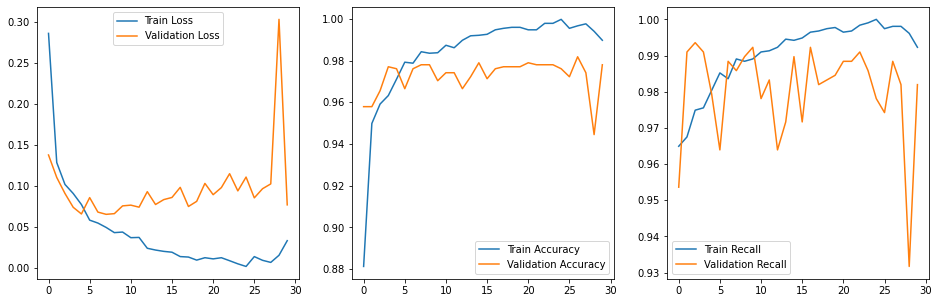

In [107]:
cnn_train_loss2 = cnn_results2.history['loss']
cnn_train_acc2 = cnn_results2.history['accuracy']
cnn_train_rec2 = cnn_results2.history['recall']
cnn_val_loss2 = cnn_results2.history['val_loss']
cnn_val_acc2 = cnn_results2.history['val_accuracy']
cnn_val_rec2 = cnn_results2.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=cnn_results2.epoch, y=cnn_train_loss2, ax=ax1, label='Train Loss')
sns.lineplot(x=cnn_results2.epoch, y=cnn_train_acc2, ax=ax2, label='Train Accuracy')
sns.lineplot(x=cnn_results2.epoch, y=cnn_train_rec2, ax=ax3, label='Train Recall')

sns.lineplot(x=cnn_results2.epoch, y=cnn_val_loss2, ax=ax1, label='Validation Loss')
sns.lineplot(x=cnn_results2.epoch, y=cnn_val_acc2, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=cnn_results2.epoch, y=cnn_val_rec2, ax=ax3, label='Validation Recall')

### Convolutional Neural Network With 2 Dropout Layers

In [15]:
cnn_model3 = Sequential()
cnn_model3.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(64, 64, 1)))
cnn_model3.add(MaxPooling2D(pool_size=(2,2)))
cnn_model3.add(Conv2D(64, (3,3), activation='relu'))
cnn_model3.add(MaxPooling2D((2,2)))
cnn_model3.add(Dropout(0.25))
cnn_model3.add(Flatten())
cnn_model3.add(Dense(64, activation='relu'))
cnn_model3.add(Dropout(0.25))
cnn_model3.add(Dense(1, activation='sigmoid'))
              
cnn_model3.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

# fitting to normal train
cnn_results3 = cnn_model3.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 29s 221ms/step - loss: 0.3158 - accuracy: 0.8655 - recall: 0.9562 - val_loss: 0.1325 - val_accuracy: 0.9502 - val_recall: 0.9394
Epoch 2/30
131/131 [==============================] - 28s 215ms/step - loss: 0.1473 - accuracy: 0.9427 - recall: 0.9652 - val_loss: 0.1176 - val_accuracy: 0.9579 - val_recall: 0.9485
Epoch 3/30
131/131 [==============================] - 28s 214ms/step - loss: 0.1154 - accuracy: 0.9568 - recall: 0.9714 - val_loss: 0.1216 - val_accuracy: 0.9579 - val_recall: 0.9961
Epoch 4/30
131/131 [==============================] - 28s 215ms/step - loss: 0.1082 - accuracy: 0.9601 - recall: 0.9736 - val_loss: 0.0683 - val_accuracy: 0.9799 - val_recall: 0.9845
Epoch 5/30
131/131 [==============================] - 28s 214ms/step - loss: 0.0951 - accuracy: 0.9654 - recall: 0.9765 - val_loss: 0.0708 - val_accuracy: 0.9751 - val_recall: 0.9794
Epoch 6/30
131/131 [==============================] - 28s 216ms/step - loss: 0.0825 -

In [16]:
cnn_model3.evaluate(validation_set)

33/33 [==============================] - 5s 153ms/step - loss: 0.1224 - accuracy: 0.9684 - recall: 0.9678


[0.12244484573602676, 0.9684210419654846, 0.967783510684967]

<AxesSubplot:>

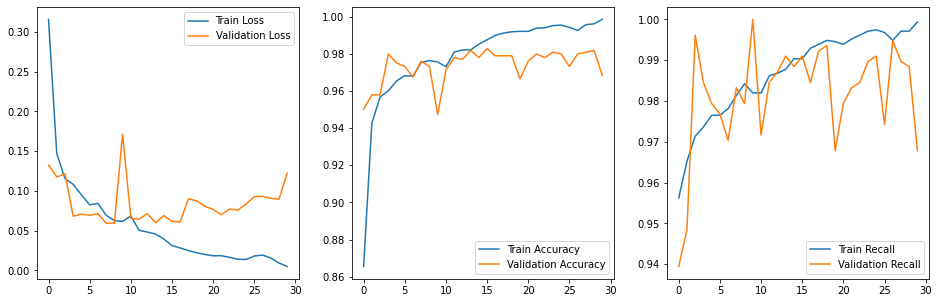

In [17]:
cnn_train_loss3 = cnn_results3.history['loss']
cnn_train_acc3 = cnn_results3.history['accuracy']
cnn_train_rec3 = cnn_results3.history['recall']
cnn_val_loss3 = cnn_results3.history['val_loss']
cnn_val_acc3 = cnn_results3.history['val_accuracy']
cnn_val_rec3 = cnn_results3.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=cnn_results3.epoch, y=cnn_train_loss3, ax=ax1, label='Train Loss')
sns.lineplot(x=cnn_results3.epoch, y=cnn_train_acc3, ax=ax2, label='Train Accuracy')
sns.lineplot(x=cnn_results3.epoch, y=cnn_train_rec3, ax=ax3, label='Train Recall')

sns.lineplot(x=cnn_results3.epoch, y=cnn_val_loss3, ax=ax1, label='Validation Loss')
sns.lineplot(x=cnn_results3.epoch, y=cnn_val_acc3, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=cnn_results3.epoch, y=cnn_val_rec3, ax=ax3, label='Validation Recall')

### Convolutional Neural Network Tuned Optimizer

In [19]:
adam = Adam(learning_rate=.005)

In [20]:
cnn_model4 = Sequential()
cnn_model4.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(64, 64, 1)))
cnn_model4.add(MaxPooling2D(pool_size=(2,2)))
cnn_model4.add(Conv2D(64, (3,3), activation='relu'))
cnn_model4.add(MaxPooling2D((2,2)))
cnn_model4.add(Dropout(0.25))
cnn_model4.add(Flatten())
cnn_model4.add(Dense(64, activation='relu'))
cnn_model4.add(Dropout(0.25))
cnn_model4.add(Dense(1, activation='sigmoid'))
              
cnn_model4.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

cnn_model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [21]:
# fitting to normal train
cnn_results4 = cnn_model4.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 29s 219ms/step - loss: 0.4525 - accuracy: 0.8110 - recall: 0.9524 - val_loss: 0.1349 - val_accuracy: 0.9531 - val_recall: 0.9729
Epoch 2/30
131/131 [==============================] - 28s 214ms/step - loss: 0.1955 - accuracy: 0.9238 - recall: 0.9556 - val_loss: 0.1345 - val_accuracy: 0.9483 - val_recall: 0.9897
Epoch 3/30
131/131 [==============================] - 28s 214ms/step - loss: 0.1498 - accuracy: 0.9429 - recall: 0.9636 - val_loss: 0.1408 - val_accuracy: 0.9435 - val_recall: 0.9304
Epoch 4/30
131/131 [==============================] - 28s 213ms/step - loss: 0.1330 - accuracy: 0.9520 - recall: 0.9685 - val_loss: 0.1034 - val_accuracy: 0.9636 - val_recall: 0.9665
Epoch 5/30
131/131 [==============================] - 28s 213ms/step - loss: 0.1166 - accuracy: 0.9572 - recall: 0.9726 - val_loss: 0.0991 - val_accuracy: 0.9598 - val_recall: 0.9807
Epoch 6/30
131/131 [==============================] - 28s 213ms/step - loss: 0.1073 -

<AxesSubplot:>

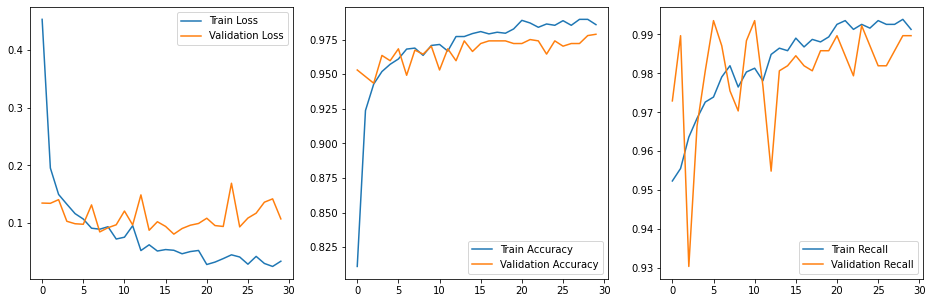

In [22]:
cnn_train_loss4 = cnn_results4.history['loss']
cnn_train_acc4 = cnn_results4.history['accuracy']
cnn_train_rec4 = cnn_results4.history['recall']
cnn_val_loss4 = cnn_results4.history['val_loss']
cnn_val_acc4 = cnn_results4.history['val_accuracy']
cnn_val_rec4 = cnn_results4.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=cnn_results4.epoch, y=cnn_train_loss4, ax=ax1, label='Train Loss')
sns.lineplot(x=cnn_results4.epoch, y=cnn_train_acc4, ax=ax2, label='Train Accuracy')
sns.lineplot(x=cnn_results4.epoch, y=cnn_train_rec4, ax=ax3, label='Train Recall')

sns.lineplot(x=cnn_results4.epoch, y=cnn_val_loss4, ax=ax1, label='Validation Loss')
sns.lineplot(x=cnn_results4.epoch, y=cnn_val_acc4, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=cnn_results4.epoch, y=cnn_val_rec4, ax=ax3, label='Validation Recall')

In [23]:
cnn_model4.evaluate(validation_set)

33/33 [==============================] - 5s 153ms/step - loss: 0.1075 - accuracy: 0.9789 - recall: 0.9897


[0.10751970112323761, 0.9789473414421082, 0.9896907210350037]

In [24]:
cnn_model4.evaluate(test_set)

20/20 [==============================] - 3s 146ms/step - loss: 1.1616 - accuracy: 0.8622 - recall: 0.9949


[1.1616331338882446, 0.8621794581413269, 0.9948717951774597]

In [25]:
final_loss, final_acc, final_rec = cnn_model4.evaluate(test_set)

20/20 [==============================] - 3s 145ms/step - loss: 1.1616 - accuracy: 0.8622 - recall: 0.9949


In [26]:
y_pred = (cnn_model4.predict(test_set) > 0.5).astype("int32")
y_pred

array([[0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
    

## Results

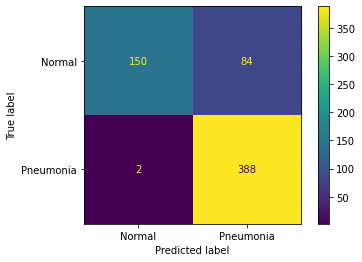

In [27]:
matrix = confusion_matrix(test_set.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                             display_labels=['Normal', 'Pneumonia'])
disp.plot()

plt.show()

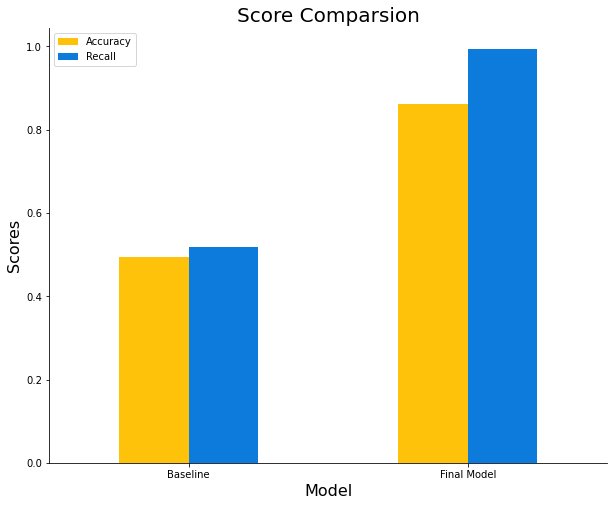

<Figure size 432x288 with 0 Axes>

In [32]:
acc = [dummy_acc, final_acc]
rec = [dummy_rec, final_rec]

rec_scores = pd.DataFrame(rec, columns=['Recall'])
acc_scores = pd.DataFrame(acc, columns=['Accuracy'])
scores = acc_scores.join(rec_scores)

# visualizing both accuracy and recall
scores.plot.bar(figsize=(10,8), color=('#FFC20A', '#0C7BDC'))
plt.xticks(ticks=[0,1], labels=['Baseline', 'Final Model'], rotation=360)
plt.ylabel('Scores',  fontsize=16)
plt.xlabel('Model',  fontsize=16)
sns.despine()
plt.title('Score Comparsion', fontsize=20)
plt.show()
plt.savefig('Graphs/score_comparison.png', dpi=300);

The final model was able to improve our accuracy from 49% to 86%, and our recall score from 50% to 99%.

This has been chosen to be our final model, because it is the least overfit and best performing in both accuracy and recall scores.


## Conclusion

In conclusion our final model was able to perform 86% accuracy, and 99% recall scores for our test set. These are great standards to have for diagnosing, since the mission of our model is to minimize false positives. Of course this model is not meant to be a doctor, and should be used in conjunction with a medical professional. In business terms, this accuracy and recall would greatly reduce costs for both patients and health providers.

Out of the 390 pneumonia cases we tested the model on, only two cases were misdiagnosed. This means that the model is currently able to correctly predict 99.5% of the test set pneumonia cases.

According to Khealth Azithromycin is a first-line treatment for adults under 65 with bacterial pneumonia. According to Enhance Health this antibiotic has a generic price point of 31.30 and brand name, Zithromax, price point of 152.16. We'll use our baseline dummy model as an example of total savings.

In the dummy model out of 4,186 observations, 583 people were diagnosed as false positives which means that it will end up costing them in total  18,247.90 if the antibiotic were generic and 88,709.28 if the antibiotic were brand name. It could cost the hospital the same or even more, as we don't imagine insurance reimburses hospitals for misdiagnosed treatments. 1,540 people were diagnosed as false negatives which will cost the patients not only in health, but money too as their situation might be more severe and they would have to pay for much longer antibiotic treatements. Health providers would also owe millions in liability.

## Next Steps

Our next steps would consist of:

-Further tuning the parameters in the convolutional neural network to get better results.

-Iterating many times over the images to see how different augmentations affect the model results.

-Expanding the demographic of patients to include 65 years olds and over as they are also very susceptible to pneumonia.

-Gathering an abundance of more data/images in order to train and produce a better model.